In [1]:
import os,gc
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import keras._tf_keras.keras
from keras._tf_keras.keras import backend as K
from segmentation_models import Unet
from segmentation_models import  get_preprocessing
from segmentation_models.losses import DiceLoss
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

2024-10-24 11:36:20.623931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 11:36:21.798199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
@dataclass
class G:
    BACKBONE = 'resnet34'
    preprocess_input = get_preprocessing(BACKBONE)# for resnet, img = (img-110.0)/1.0

In [3]:
path = os.path.join(os.getcwd(),'data')
train = pd.read_csv(path + '/train.csv')

In [12]:
train2 = train.pivot(index='ImageId', columns='ClassId', 
                     values='EncodedPixels')
del train
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:]!='',axis=1).values
train2 = pd.DataFrame(train2.to_records())
train2.rename(columns={"1":"e1","2":"e2","3":"e3","4":"e4"}, inplace=True)
train2path = os.path.join(os.getcwd(), 'data')
train = pd.read_csv(path + '/train.csv')
train.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

### Utility Function

In [13]:
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask

### Data Generator

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + '/train_images/'
        elif self.subset == "test":
            self.data_path = path + '/test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

### Train EDA

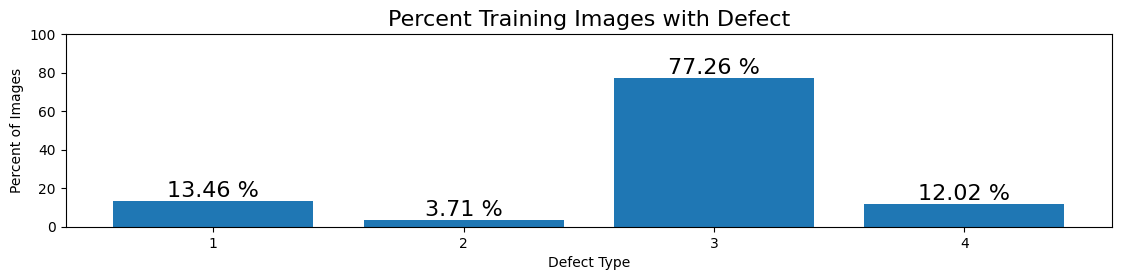

In [15]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0))
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:    
    height = rect.get_height()    
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,100)); plt.show()

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


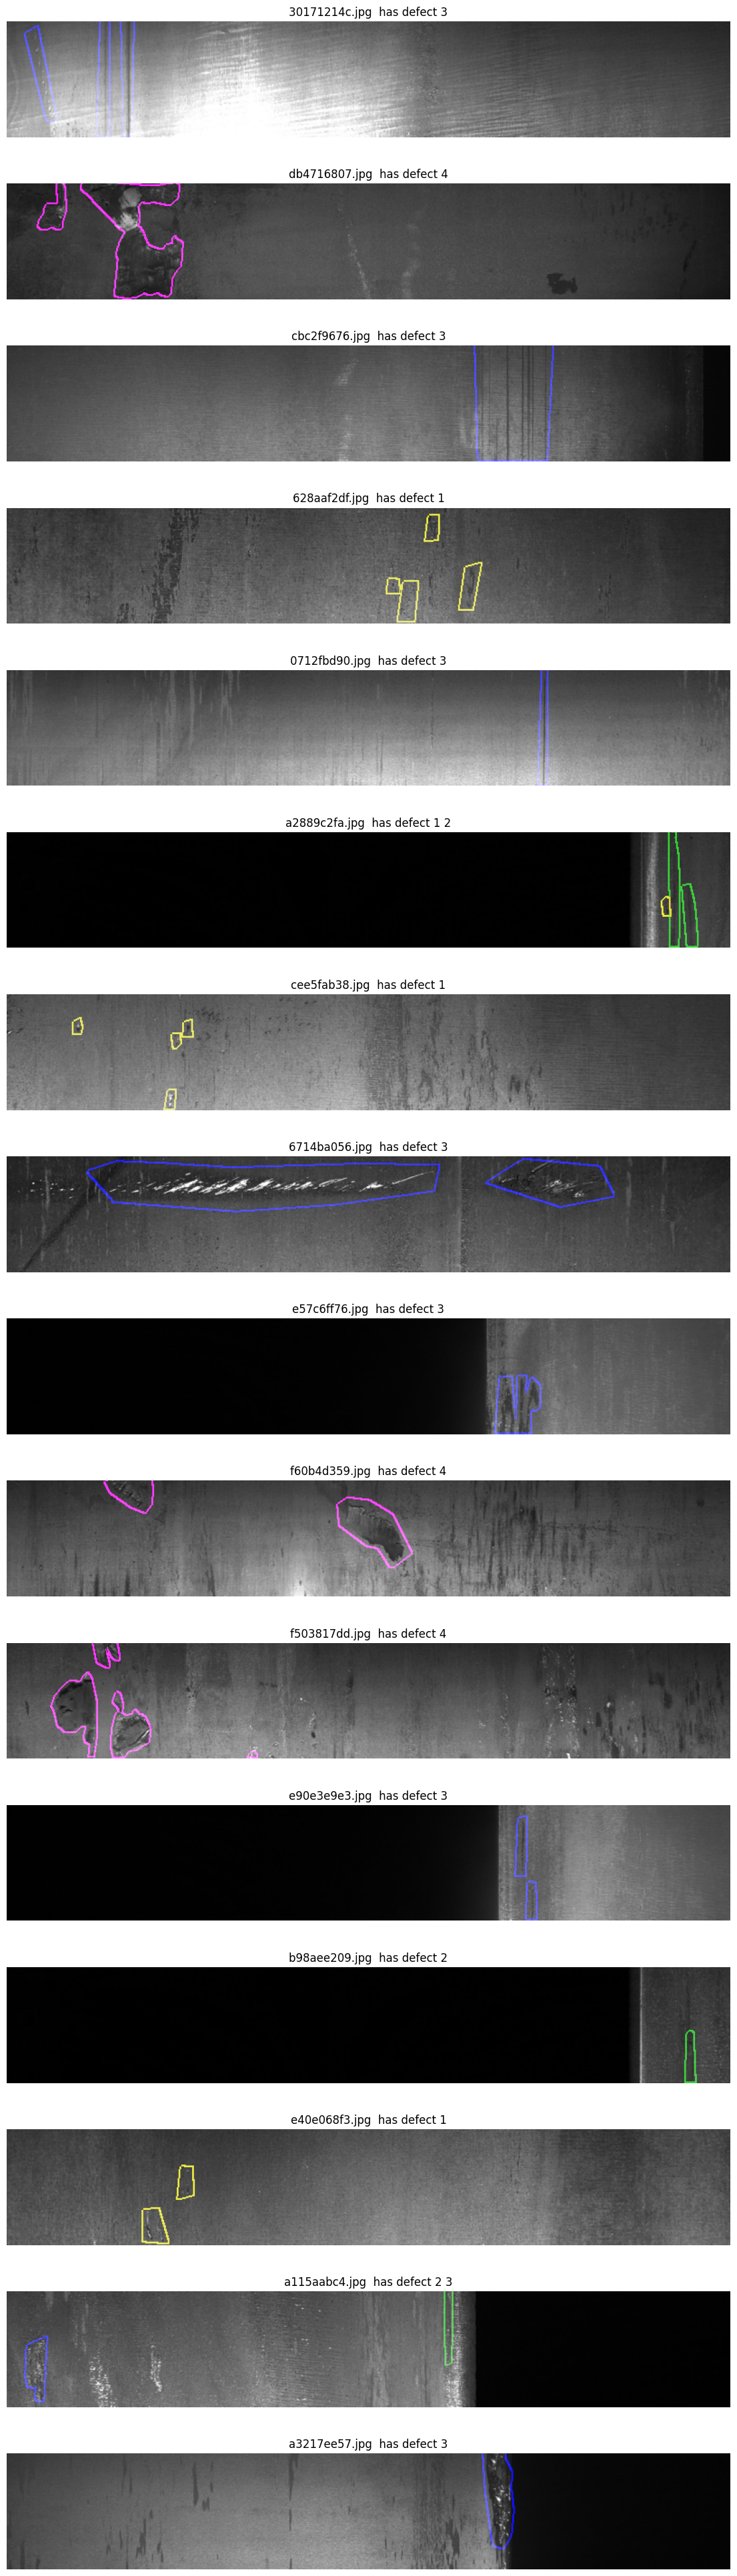

In [17]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    if i != 0: break
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Download UNET

In [147]:
# COMPETITION METRIC
#import tensorflow.experimental.numpy as tnp
def dice_coef(y_true, y_pred, smooth=1):
#    tnp.experimental_enable_numpy_behavior(prefer_float32=True)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [156]:
# LOAD UNET WITH PRETRAINING FROM IMAGENET
model = Unet(G.BACKBONE, input_shape=(128, 800, 3), classes=4, 
             activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [157]:
# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); 
train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,
                              preprocess=G.preprocess_input)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=G.preprocess_input)
history = model.fit(train_batches, validation_data = valid_batches, epochs 
= 30, verbose=2)

Epoch 1/30


I0000 00:00:1729704343.279563   11840 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_38', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_33', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_27', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 4 by

333/333 - 180s - 540ms/step - dice_coef: 0.4004 - loss: 0.0960 - val_dice_coef: 0.7423 - val_loss: 0.0334
Epoch 2/30
333/333 - 141s - 423ms/step - dice_coef: 0.8511 - loss: 0.0307 - val_dice_coef: 0.4020 - val_loss: 0.0684
Epoch 3/30
333/333 - 141s - 423ms/step - dice_coef: 0.9080 - loss: 0.0297 - val_dice_coef: 0.8095 - val_loss: 0.0317
Epoch 4/30
333/333 - 141s - 422ms/step - dice_coef: 0.9606 - loss: 0.0280 - val_dice_coef: 1.0704 - val_loss: 0.0275
Epoch 5/30
333/333 - 141s - 422ms/step - dice_coef: 1.0017 - loss: 0.0270 - val_dice_coef: 1.0998 - val_loss: 0.0240
Epoch 6/30
333/333 - 141s - 422ms/step - dice_coef: 1.0949 - loss: 0.0240 - val_dice_coef: 1.0039 - val_loss: 0.0274
Epoch 7/30
333/333 - 141s - 422ms/step - dice_coef: 1.0907 - loss: 0.0241 - val_dice_coef: 1.2372 - val_loss: 0.0280
Epoch 8/30
333/333 - 141s - 422ms/step - dice_coef: 1.0973 - loss: 0.0237 - val_dice_coef: 1.1637 - val_loss: 0.0228
Epoch 9/30
333/333 - 141s - 423ms/step - dice_coef: 1.1585 - loss: 0.0216 -

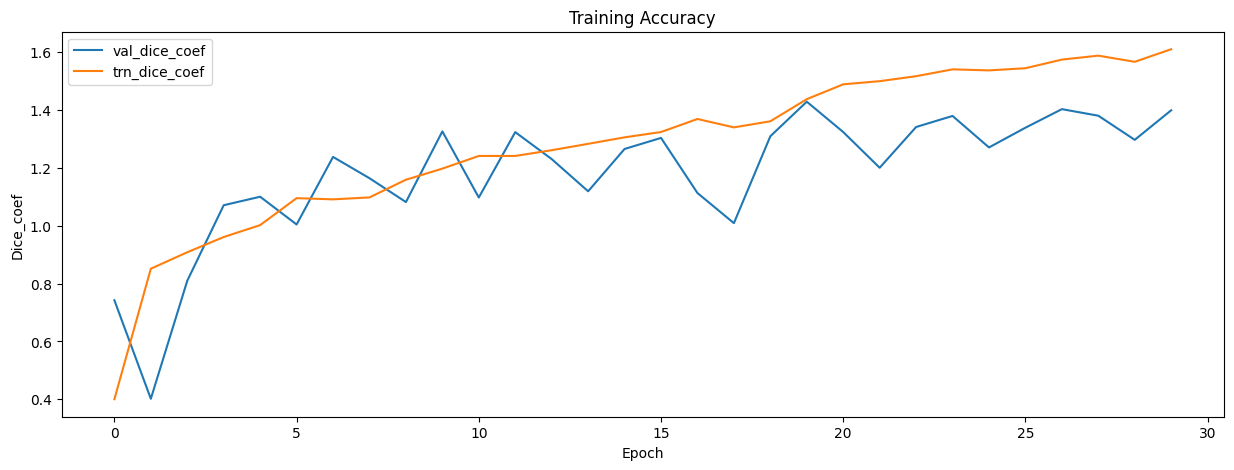

In [158]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

In [15]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS)
val_set = train2.iloc[idx:]
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)],
                              preprocess=G.preprocess_input)
preds = model.predict(valid_batches,verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


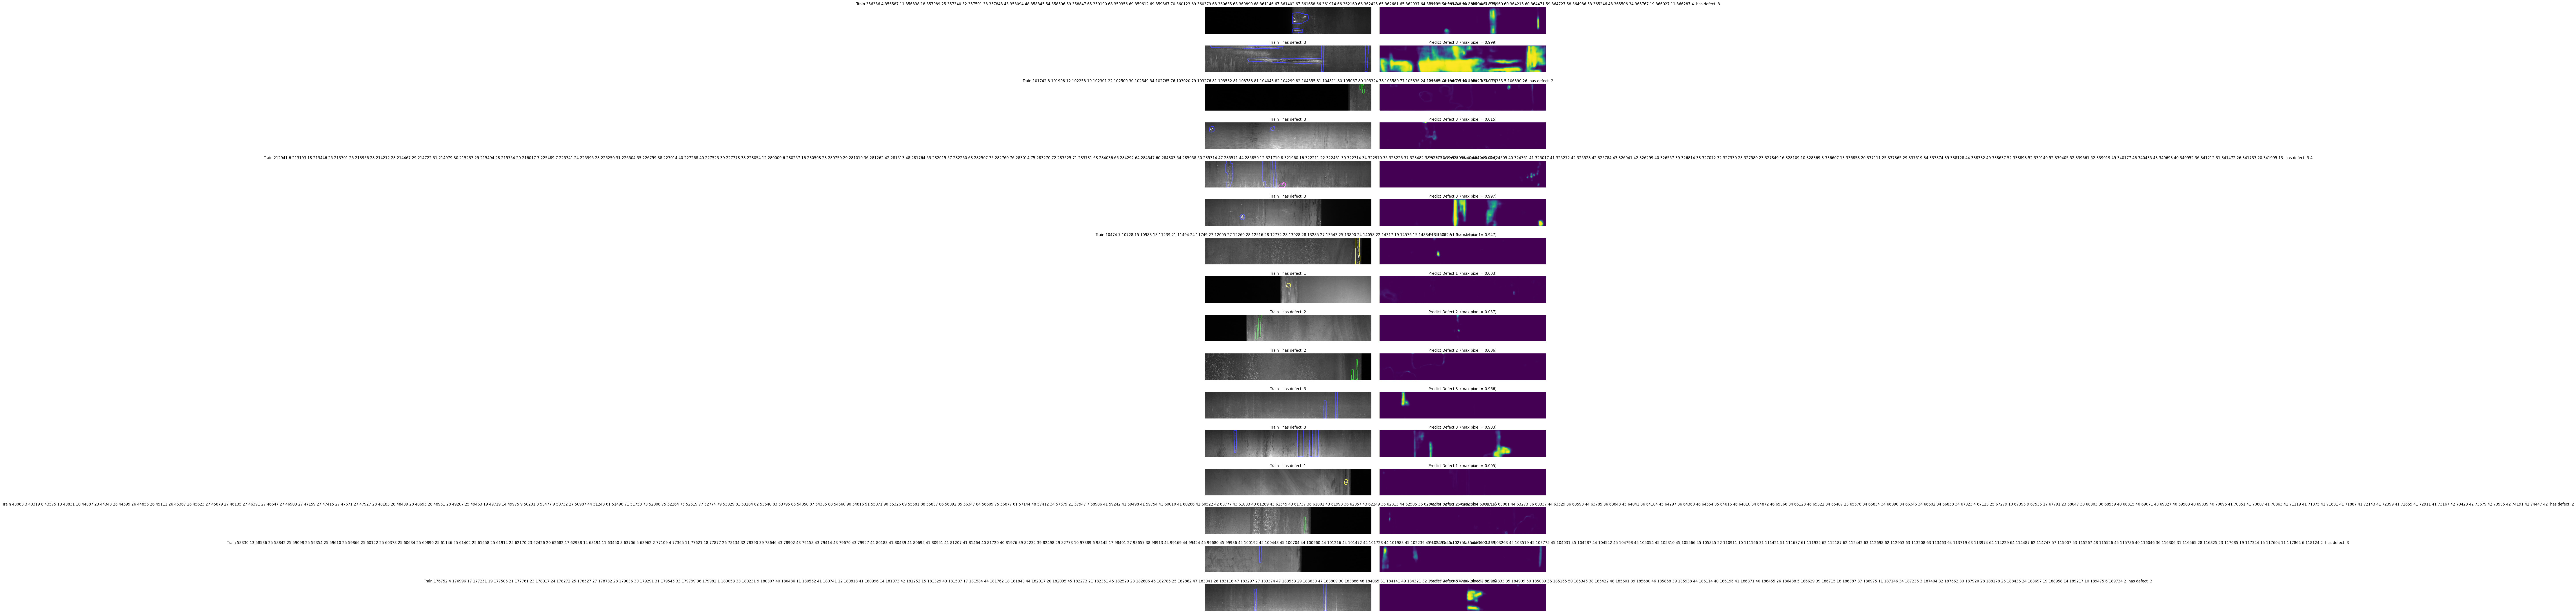

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('bool') with casting rule 'same_kind'

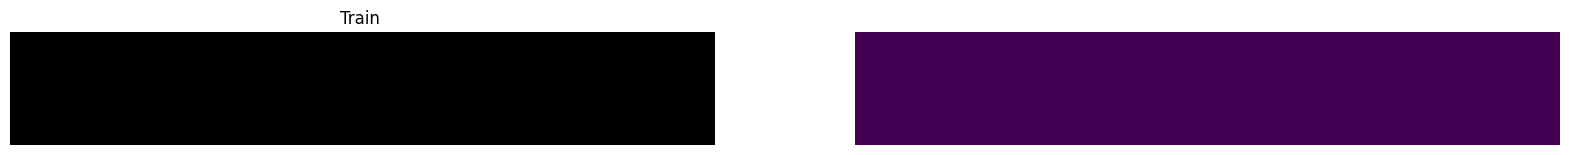

In [18]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
    #        msk = preds[i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
    #    mx = np.round(np.max(msk),3)
    #    plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()